# Analysis of MTA Permanent Art Collection

## Introduction
The MTA Permanent Art Program features hundreds of artworks across New York City subway stations.  
In this analysis, I will clean the dataset and explore three main questions:  
1. Which subway lines have the most artworks?  
2. Which artists appear most often?  
3. What materials are most commonly used by decade?

In [65]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re 
import unicodedata

# Load dataset
df = pd.read_csv("MTA_Permanent_Art_Catalog__Beginning_1980_20250927.csv")
df.head()

,Agency,Station Name,Line,Artist,Art Title,Art Date,Art Material,Art Description,Art Image Link
0,NYCT,Clark St,"2,3",Ray Ring,Clark Street Passage,1987,Terrazzo floor tile,The first model that Brooklyn-born artist Ray ...,https://new.mta.info/agency/arts-design/collec...
1,NYCT,125 St,"4,5,6",Houston Conwill,The Open Secret,1986,Bronze - polychromed,"The Open Secret, in the 125th Street and Lexin...",https://new.mta.info/agency/arts-design/collec...
2,NYCT,Astor Pl,6,Milton Glaser,Untitled,1986,Porcelain enamel murals,"Milton Glaser, best known for his work in grap...",https://new.mta.info/agency/arts-design/collec...
3,NYCT,Kings Hwy,"B,Q",Rhoda Andors,Kings Highway Hieroglyphs,1987,Porcelain Enamel Murals on Steel,The artist discusses her work: ÒIf public art...,https://new.mta.info/agency/arts-design/collec...
4,NYCT,Newkirk Av,"B,Q",David Wilson,Transit Skylight,1988,Zinc-glazed Apolycarbonate skylight,"The artist recalls, ÒAbout the same time that ...",https://new.mta.info/agency/arts-design/collec...


# Initial Cleaning
Based on the preview of the data, we can see a glimpse of the data that we are working with. To simplify the dataset, I dropped columns that were not needed.  
I then removed duplicates by station name, filtered out all other agencies except NYCT, and standardized text to lowercase.

In [66]:
# Drop unwanted columns and remove duplicates/NaNs
df = df.drop(columns=["Art Title", "Art Description", "Art Image Link"])
df = df.dropna()
df = df.drop_duplicates(subset=["Station Name"])

# Remove Metro-North and LIRR entries
df = df[~df['Agency'].str.contains('Metro North|LIRR|B&T', case=False)]

# Apply strip + lowercase to all object (string) columns
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].str.strip().str.lower()

df.head()

,Agency,Station Name,Line,Artist,Art Date,Art Material
0,nyct,clark st,"2,3",ray ring,1987,terrazzo floor tile
1,nyct,125 st,"4,5,6",houston conwill,1986,bronze - polychromed
2,nyct,astor pl,6,milton glaser,1986,porcelain enamel murals
3,nyct,kings hwy,"b,q",rhoda andors,1987,porcelain enamel murals on steel
4,nyct,newkirk av,"b,q",david wilson,1988,zinc-glazed apolycarbonate skylight


# Q1. Which subway lines have the most artworks?  

To look at which subway lines have the most artworks, I first cleaned the `Line` column by splitting multiple lines into separate rows. This way, if an artwork appeared on more than one line, it was counted correctly for each. 

In [67]:
df = df.assign(Line=df['Line'].str.split(',')).explode('Line')
df['Line'] = df['Line'].str.strip()
df = df.dropna(subset=["Line"])

df.head()

,Agency,Station Name,Line,Artist,Art Date,Art Material
0,nyct,clark st,2,ray ring,1987,terrazzo floor tile
0,nyct,clark st,3,ray ring,1987,terrazzo floor tile
1,nyct,125 st,4,houston conwill,1986,bronze - polychromed
1,nyct,125 st,5,houston conwill,1986,bronze - polychromed
1,nyct,125 st,6,houston conwill,1986,bronze - polychromed


After tidying, I used a count of artworks per line and plotted the top 10 subway lines.  

From the results, the lines with the most artworks are the **2, 5, 6, q, and 3 lines**. These are some of the busiest subway routes in New York City, which makes sense because major stations along these lines are more likely to feature public art projects. The visualization highlights how the artworks are not evenly spread across all subway lines but are concentrated on those with the highest passenger traffic and major transfer points.

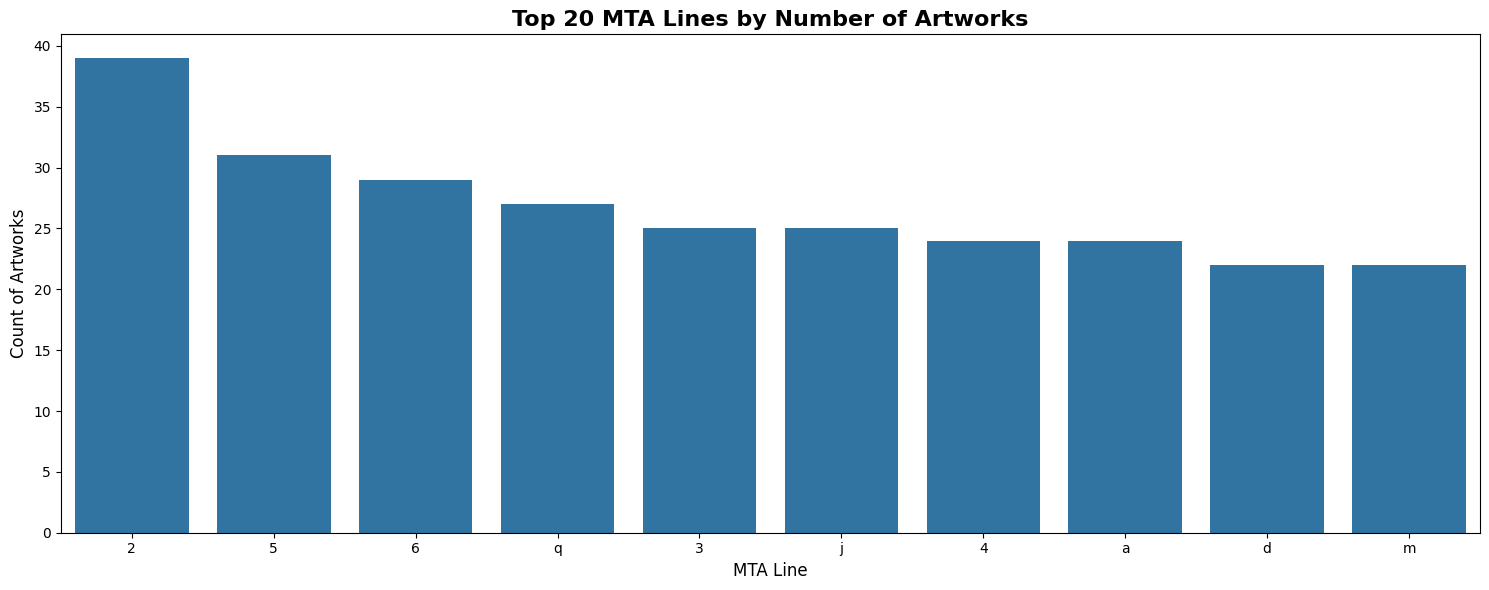

In [68]:
# Top 10 MTA lines
top10_lines = df["Line"].value_counts().head(10).index
df_top10 = df[df["Line"].isin(top10_lines)]

# Plot top 10 lines
plt.figure(figsize=(15,6))
sns.countplot(
    data=df_top10, 
    x="Line", 
    order=top10_lines
)
plt.title("Top 20 MTA Lines by Number of Artworks", fontsize=16, weight="bold")
plt.xlabel("MTA Line", fontsize=12)
plt.ylabel("Count of Artworks", fontsize=12)
plt.tight_layout()
plt.show()

# Q2. Which artists have the most artworks?  

To see which artists have contributed the most artworks, I first cleaned the `Artist` column. This involved fixing special characters, splitting artists who collaborated, and exploding the list so that each artist was counted individually. Once the data was tidy, I created a count of artworks by artist and plotted the top 10.  


In [69]:
# Function to clean text
def clean_text(s):
    if pd.isna(s):
        return ""
    s = unicodedata.normalize("NFKD", s)
    s = s.encode("ascii", "ignore").decode("utf-8")
    s = re.sub(r"\s+", " ", s)
    s = s.replace("&", "and")
    return s.strip()

# Clean and explode artists
df["Artist"] = df["Artist"].apply(clean_text)
df["Artist"] = df["Artist"].apply(lambda x: re.split(r"\band\b", x, flags=re.IGNORECASE))
df = df.explode("Artist")
df["Artist"] = df["Artist"].str.strip()
df = df[df["Artist"] != ""]

From the results, the most frequent contributors are **Norman B Colp, Jacob Lawrence, Kathleen McCarthy, George Trakas (in collaboration with di Domenico + Partners), and Michele Oka Doner**. This shows that both individual artists and design groups have played a significant role in shaping the artistic identity of the subway system.

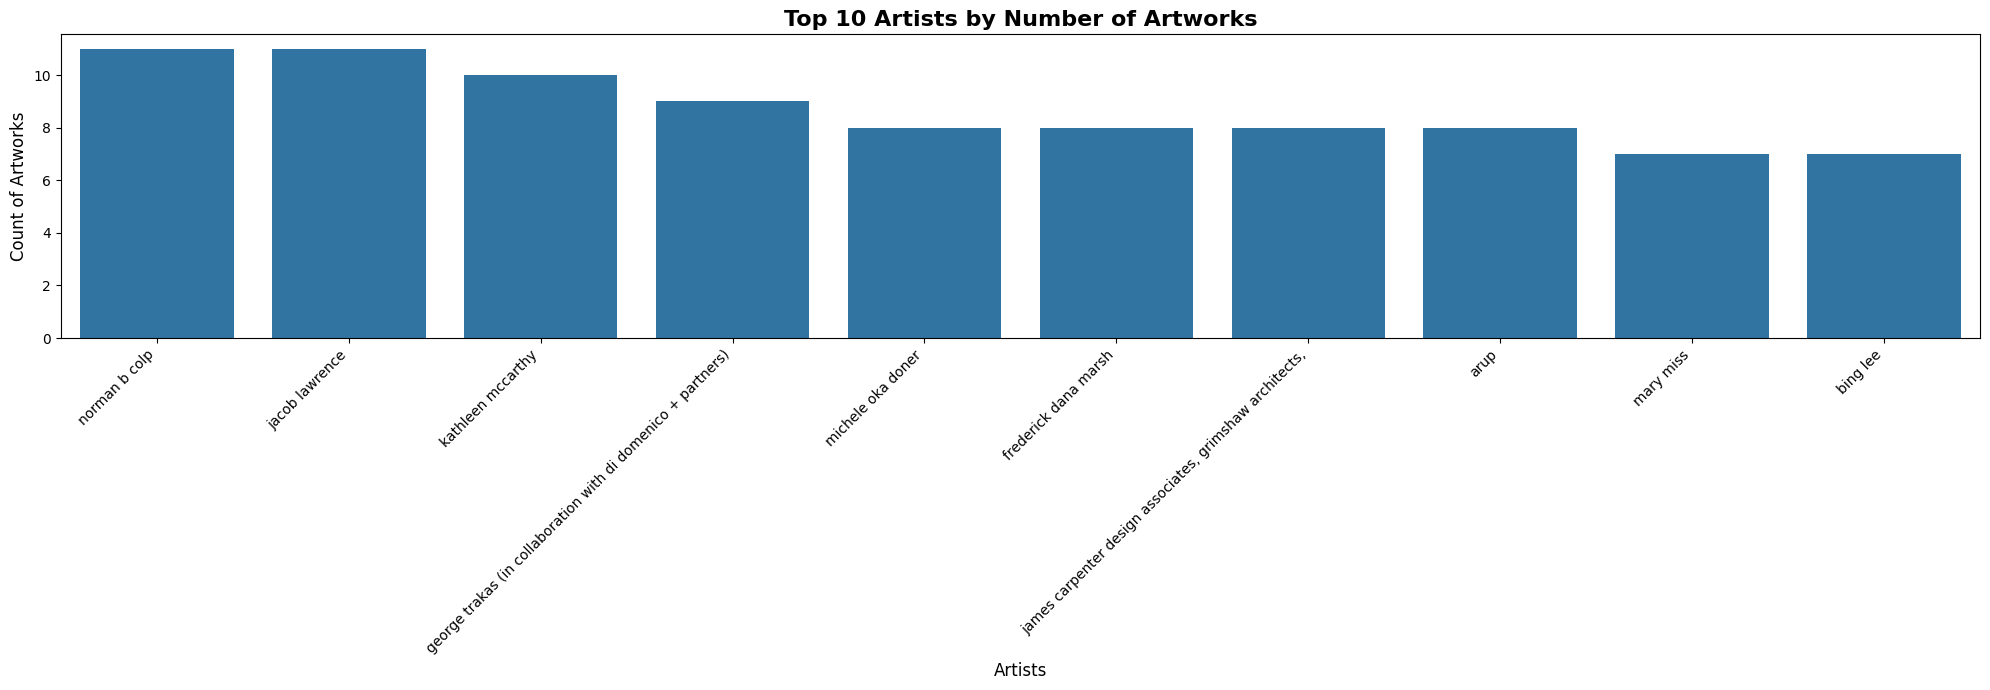

In [70]:
# Top 10 artists
top10_artists = df["Artist"].value_counts().head(10).index

plt.figure(figsize=(20,7))
sns.countplot(
    data=df[df["Artist"].isin(top10_artists)], 
    x="Artist", 
    order=top10_artists
)
plt.title("Top 10 Artists by Number of Artworks", fontsize=16, weight="bold")
plt.xlabel("Artists", fontsize=12)
plt.ylabel("Count of Artworks", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Q3. What materials are most commonly used by decade?  

To see how material choices changed over time, I grouped the artworks by the decade of their installation and then looked at the most common materials used in each period. I first cleaned and standardized the `Art Material` column to make sure that variations (like “stainless steel” vs. “stainless”) were counted together. I also split artworks with multiple materials so that each was counted separately.  


In [71]:
# Function to tidy Art Material column
def tidy_material(material_series):
    s = material_series.str.lower().str.strip()
    s = s.str.replace(r"\(.*?\)", "", regex=True)
    s = s.str.replace(r"(throughout|in passageway|on .*|in .*|with .*|etc\.)", "", regex=True)
    s = s.str.replace(r"[;/]", ",", regex=True)
    s = s.str.split(r",| and ").explode().str.strip()
    s = s[s != ""]
    standard_map = {
        "aluminum - painted": "aluminum",
        "cast aluminum": "aluminum",
        "bronze - hand forged": "bronze",
        "bronze - patinated": "bronze",
        "bronze - polychromed": "bronze",
        "bronze and steel sheet": "bronze and steel",
        "stainless": "steel",
        "stainless steel": "steel",
        "steel with galvinized steel cable": "steel",
        "cast concrete": "concrete",
        "concrete - jesmonite castings": "concrete",
        "faceted glass": "glass",
        "fused glass": "glass",
        "glass mosaic": "glass",
        "laminated glass": "glass",
        "glass blocks": "glass",
        "glass block": "glass",
        "glass, ceramic mosaic": "glass and ceramic",
        "glass and ceramic mosaic": "glass and ceramic",
        "ceramic tile, glass mosaic": "ceramic and glass",
        "ceramic tile, glass mosaic": "ceramic and glass",
        "porcelain enamel murals": "porcelain",
        "porcelain enamel murals on steel": "porcelain and steel",
        "porcelain enamel on steel": "porcelain and steel",
        "wrought ir": "iron",
        "wrought iron": "iron",
        "stone - etched granite": "stone",
        "stone - absolute black granite": "stone",
        "marble and stone mosaic": "marble and stone",
        "marble mosaic walls": "marble",
        "terracotta": "ceramic",
        "terrazzo floor tile": "terrazzo",
        "zinc-glazed apolycarbonate skylight": "zinc-glass",
        "red clay": "clay",
        "glazes": "glaze",
        "mirrors": "mirror",
        "lighting elements": "lighting",
        "electronic light controllers": "lighting",
    }
    return s.replace(standard_map).reset_index(drop=True)

# Apply tidy_material
df = df.assign(**{"Art Material": tidy_material(df["Art Material"])})
df['Art Material'] = df['Art Material'].str.strip().str.lower()

# Top 10 materials
top10_materials = df['Art Material'].value_counts().head(10).index
df_top10 = df[df['Art Material'].isin(top10_materials)]

The results show clear patterns. In the 1980s and 1990s, **ceramic, mosaic, and bronze** were the most popular materials, reflecting a traditional style of subway art. In the 2000s, **glass and steel** became much more common, likely because of advances in fabrication and a growing preference for modern, durable materials. By the 2010s and 2020s, **glass mosaics and steel** dominated, showing how the MTA increasingly invested in materials that balance both visual impact and long-term resilience.  

C:\Users\yulau\AppData\Local\Temp\ipykernel_12144\1345573240.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_materials = top_materials.groupby("Decade", group_keys=False).apply(


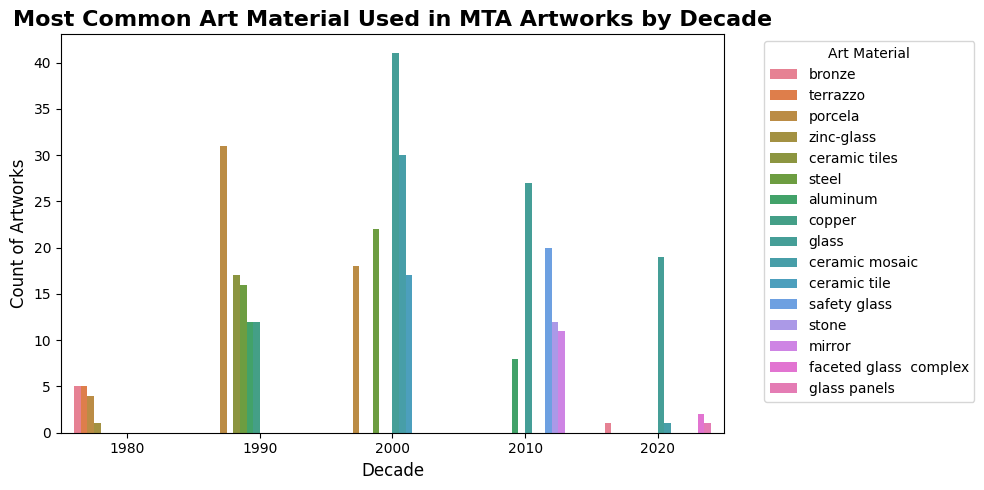

In [72]:
# Convert Art Date to decade
df["Art Date"] = pd.to_numeric(df["Art Date"], errors="coerce")
df = df.dropna(subset=["Art Date"])
df["Decade"] = (df["Art Date"] // 10 * 10).astype(int)

# Count top 5 materials per decade
top_materials = (
    df.groupby(["Decade", "Art Material"])
    .size()
    .reset_index(name="Count")
)

top_materials = top_materials.groupby("Decade", group_keys=False).apply(
    lambda x: x.nlargest(5, "Count")
)
top_materials.head()

# Plot results
plt.figure(figsize=(10,5))
sns.barplot(data=top_materials, x="Decade", y="Count", hue="Art Material")
plt.title("Most Common Art Material Used in MTA Artworks by Decade", fontsize=16, weight="bold")
plt.xlabel("Decade", fontsize=12)
plt.ylabel("Count of Artworks", fontsize=12)
plt.legend(title="Art Material", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()